# Importing the packages and data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.special import gamma, digamma, polygamma
import math
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import random

import scipy.optimize
from scipy.stats import ttest_ind
from scipy.optimize import Bounds

from prettytable import PrettyTable

In [3]:
from multiprocessing import Pool
from functools import partial

In [4]:
import sys
sys.path.append("../smote_cd/")
import smote_cd

In [5]:
import sys
sys.path.append("../../coral_mapping/")
import segments_regressor
import coral_map_tests

In [6]:
import dirichlet_regression

In [15]:
# sur ordi MQ:
scipy.__version__

'1.9.1'

In [77]:
# sur mon ordi perso:
scipy.__version__

'1.4.1'

In [7]:
def cos_similarity(x1,x2):
    return(np.mean([np.dot(x1[i],x2[i])/(np.linalg.norm(x1[i])*np.linalg.norm(x2[i])) for i in range(len(x1))]))

# Loading Maupiti data

In [8]:
img_B02 = np.load('../../maupiti/Satellite Images/sentinel_B2_new.npy')
img_B03 = np.load('../../maupiti/Satellite Images/sentinel_B3_new.npy')
img_B04 = np.load('../../maupiti/Satellite Images/sentinel_B4_new.npy')
img_B08 = np.load('../../maupiti/Satellite Images/sentinel_B8_new.npy')

In [9]:
img_B02 = np.load('../../maupiti/Satellite Images/sentinel_B2_20220828.npy')
img_B03 = np.load('../../maupiti/Satellite Images/sentinel_B3_20220828.npy')
img_B04 = np.load('../../maupiti/Satellite Images/sentinel_B4_20220828.npy')
img_B08 = np.load('../../maupiti/Satellite Images/sentinel_B8_20220828.npy')

In [10]:
maupiti_zones = np.load('../../maupiti/Satellite Images/sentinel_rugo_new.npy')
#maupiti_zones = np.load('../maupiti/Satellite Images/sentinel_rugo_new_grouped_8.npy')

In [25]:
zones = ['NONE', 'CAER', 'CCDR', 'CFCO', 'CMCD', 'CRER', 'CSAG', 'CSHR', 'CTSR', 'DW', 'SDS', 'SLSC', 'SMSC', 'SSS', 'SSSC']

In [11]:
map_test=coral_map_tests.coral_map([img_B02,img_B03,img_B04,img_B08], map_img=maupiti_zones)

In [12]:
map_test.segmentation(method='fz',scale=0.9, min_size=40)
np.max(map_test.segments)

2322

In [13]:
boundaries = coral_map_tests.find_boundaries(map_test.segments)
adjacent_segments,_ = segments_regressor.find_adjacent_segments(map_test.segments, boundaries)

In [14]:
X_maupiti = segments_regressor.create_features(map_test.segments, map_test.blue_band, map_test.green_band, map_test.red_band, map_test.nir_band)
Y_maupiti = coral_map_tests.create_labels_dataset(map_test.segments,map_test.map_img)

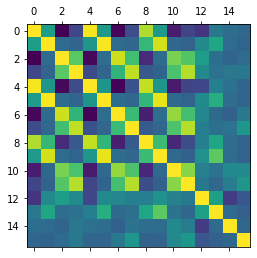

In [15]:
plt.matshow(X_maupiti.corr())
plt.show()

In [16]:
# Create correlation matrix
corr_matrix = X_maupiti.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.4)]

# Drop features 
X_maupiti_less_features = X_maupiti.drop(to_drop, axis=1)

In [17]:
X_maupiti_less_features.corr()

,mean_blue,var_blue,mean_nir,skew_nir,kurt_nir
mean_blue,1.000000,0.338209,-0.259352,0.052624,0.004406
var_blue,0.338209,1.000000,0.213142,0.030445,-0.005806
mean_nir,-0.259352,0.213142,1.000000,-0.222240,-0.080753
skew_nir,0.052624,0.030445,-0.222240,1.000000,0.009483
kurt_nir,0.004406,-0.005806,-0.080753,0.009483,1.000000


In [18]:
n_features = 5
n_classes = 15
n_samples = X_maupiti.shape[0]

In [19]:
Y_star_maupiti = (Y_maupiti*(n_samples-1)+1/n_classes)/n_samples

In [20]:
Z_maupiti = np.ones((n_samples,n_features))

In [21]:
Z_maupiti = np.ones(n_samples).reshape(-1,1)
#Z_maupiti = np.ones((n_samples,2))
#Z_maupiti[:,1] = np.array(X_maupiti)[:,0]/np.max(np.array(X_maupiti)[:,0])

In [22]:
W_maupiti = np.zeros((n_samples,n_samples))
for i in range(n_samples):
    W_maupiti[i,adjacent_segments[i]]=1

W_maupiti = W_maupiti/W_maupiti.sum(axis=1)[:,None]

In [23]:
n_features = 5
X = StandardScaler().fit(X_maupiti_less_features).transform(X_maupiti_less_features)

In [71]:
n_features = 16
X = StandardScaler().fit(X_maupiti).transform(X_maupiti)

In [24]:
train_ind, test_ind = train_test_split(np.arange(len(X)),test_size=0.2)

X_train, X_test = X[train_ind], X[test_ind]
Y_train, Y_test = Y_star_maupiti[train_ind], Y_star_maupiti[test_ind]
Z_train, Z_test = Z_maupiti[train_ind], Z_maupiti[test_ind]
W_train, W_test = W_maupiti[train_ind][:,train_ind], W_maupiti[test_ind][:,test_ind]

# Regressor

## With 16 features

### With Loglikelihood

In [173]:
%%time
reg = dirichlet_regression.dirichletRegressor()
reg.fit(X_train, Y_train, parametrization='alternative', gamma_0=[0.], Z=Z_train)

Optimization terminated successfully.
Wall time: 194 ms


In [174]:
r2_score(Y_train,reg.mu)

-0.3669724600383802

In [177]:
cos_similarity(Y_train, reg.mu)

0.4896360902219614

In [175]:
mu_pred = reg.pred(X_test)

In [176]:
r2_score(Y_test,mu_pred)

-55.89609052034208

### With crossentropy, no spatial

In [178]:
%%time
reg = dirichlet_regression.dirichletRegressor()
reg.fit(X_train, Y_train, loss='crossentropy')

Optimization terminated successfully.
Wall time: 1.11 s


In [179]:
r2_score(Y_train,reg.mu)

0.23928635598847078

In [182]:
cos_similarity(Y_train,reg.mu)

0.7000390704448054

In [180]:
mu_pred = reg.pred(X_test)

In [181]:
r2_score(Y_test,mu_pred)

0.08641831082988417

In [40]:
betas_true = np.zeros((n_features+1,n_classes))
betas_true[:,1:] = reg.beta

### With crossentropy, spatial

In [160]:
%%time
reg = dirichlet_regression.dirichletRegressor(spatial=True)
reg.fit(X_train, Y_train, W=W_train, loss='crossentropy')

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Wall time: 17min 25s


In [161]:
r2_score(Y_train,reg.mu)

0.6105318463476359

In [162]:
mu_pred = reg.pred(X_test, W_test)

In [163]:
r2_score(Y_test,mu_pred)

-3.1075760837067934

In [164]:
cos_similarity(Y_test,mu_pred)

0.6327776844930929

## Generating new data

In [80]:
reg.beta[0]

array([ -3.50401695,  -4.70527698,  -2.47142614,  -1.59140165,
       -13.06053632,  -1.76582839,  -1.8256111 ,  -4.20918389,
       -32.69730236,  -5.50253816,  -3.57923636,  -3.52476712,
        -4.11480807,  -3.79375222])

In [137]:
X_gen = np.random.normal(0, 1, np.shape(X))

In [147]:
#betas_gen = np.random.uniform(size=(n_features+1,n_classes))
betas_gen = np.random.uniform(size=(n_features+1,8))
betas_gen[:,0] = 0.
X_1 = np.ones((n_samples,n_features+1))
X_1[:,1:] = X_gen

In [148]:
#mu_pred = reg.pred(X_gen)
mu_pred = dirichlet_regression.compute_mu(X_1, betas_gen)
phi = np.ones(n_samples)
alpha = np.copy(mu_pred)

In [149]:
#Y_gen_1 = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
Y_gen = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
Y_gen = (Y_gen*(n_samples-1)+1/n_classes)/n_samples

In [150]:
%%time
reg_new = dirichlet_regression.dirichletRegressor()
reg_new.fit(X_gen, Y_gen, parametrization='common')

Optimization terminated successfully.
Wall time: 50 ms


In [151]:
r2_score(Y_gen,reg_new.mu)

0.057061089011778685

In [152]:
cos_similarity(Y_gen,reg_new.mu)

0.5402615383500412

In [153]:
mean_squared_error(betas_gen[:,1:],reg_new.beta,squared=False)

0.4189180378251051

In [154]:
%%time
reg_new = dirichlet_regression.dirichletRegressor()
reg_new.fit(X, Y_gen, parametrization='alternative', Z=np.ones((n_samples,1)))

Optimization terminated successfully.
Wall time: 58.3 ms


In [155]:
cos_similarity(Y_gen,reg_new.mu)

0.49097839078024097

In [208]:
cos_sim_temp = []
r2_temp = []
for _ in range(100):
    temp1 = np.random.normal(0, 1, (1000,15))
    temp2 = np.random.normal(0, 1, (1000,15))
    cos_sim_temp.append(cos_similarity(temp1,temp2))
    r2_temp.append(r2_score(temp1,temp2))
print(np.mean(cos_sim_temp))
print(np.mean(r2_temp))

-0.00047197799237281326
-1.0025759304464372


In [209]:
cos_sim_temp = []
r2_temp = []
for _ in range(100):
    temp1 = np.random.normal(0, 1, (1000,3))
    temp2 = np.random.normal(0, 1, (1000,3))
    cos_sim_temp.append(cos_similarity(temp1,temp2))
    r2_temp.append(r2_score(temp1,temp2))
print(np.mean(cos_sim_temp))
print(np.mean(r2_temp))

-0.0027827969065342974
-1.0159591907735699


### Scores depending on number of classes

In [62]:
list_X_gen = [np.random.normal(0, 1, np.shape(X)) for _ in range(10)]

In [186]:
phi = np.ones(n_samples)
list_r2_scores = []
list_cos_similarity = []

for j in range(3,20):
    l_r2_temp = []
    l_cos_similarity_temp = []
    for X_gen in list_X_gen:
        betas_gen = np.random.uniform(size=(n_features+1,j))
        betas_gen[:,0] = 0.
        X_1 = np.ones((n_samples,n_features+1))
        X_1[:,1:] = X_gen
        mu_pred = dirichlet_regression.compute_mu(X_1, betas_gen)
        alpha = np.copy(mu_pred)
        Y_gen = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
        Y_gen = (Y_gen*(n_samples-1)+1/n_classes)/n_samples
        reg_new = dirichlet_regression.dirichletRegressor()
        reg_new.fit(X_gen, Y_gen, parametrization='common')
        l_r2_temp.append(r2_score(Y_gen,reg_new.mu))
        l_cos_similarity_temp.append(cos_similarity(Y_gen,reg_new.mu))
    list_r2_scores.append(l_r2_temp)
    list_cos_similarity.append(l_cos_similarity_temp)

Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization

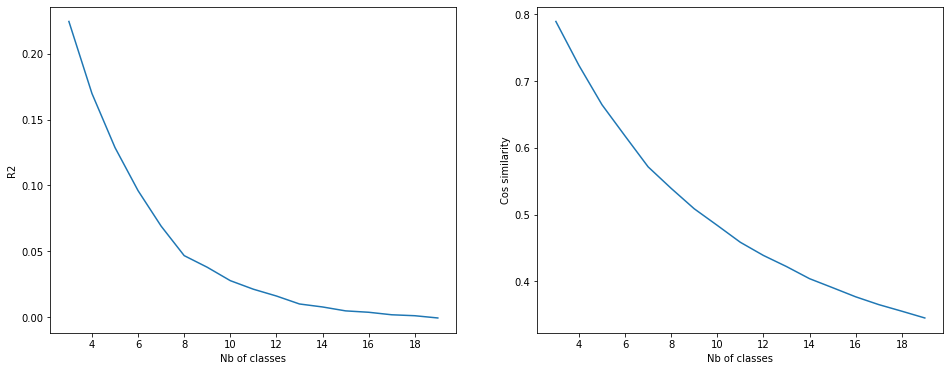

In [199]:
fig,ax = plt.subplots(1,2,figsize=(16,6))

ax[0].plot(np.arange(3,20), np.mean(list_r2_scores,axis=1))
ax[0].set_ylabel('R2')
ax[0].set_xlabel('Nb of classes')

ax[1].plot(np.arange(3,20), np.mean(list_cos_similarity,axis=1))
ax[1].set_ylabel('Cos similarity')
ax[1].set_xlabel('Nb of classes')

#plt.savefig('scores depending on nb class.png')
plt.show()

In [61]:
from sklearn.linear_model import LogisticRegression

In [80]:
list_accuracy = []

for j in range(3,20):
    l_acc_temp = []
    for X_gen in list_X_gen:
        betas_gen = np.random.uniform(size=(n_features+1,j))
        betas_gen[:,0] = 0.
        X_1 = np.ones((n_samples,n_features+1))
        X_1[:,1:] = X_gen
        mu_pred = dirichlet_regression.compute_mu(X_1, betas_gen)
        alpha = np.copy(mu_pred)
        Y_gen = np.array([np.argmax(np.random.multinomial(1,alpha_i)) for alpha_i in alpha])
        logistic = LogisticRegression()
        logistic.fit(X_gen, Y_gen)
        l_acc_temp.append(np.sum(Y_gen==logistic.predict(X_gen))/len(Y_gen))
    list_accuracy.append(l_acc_temp)

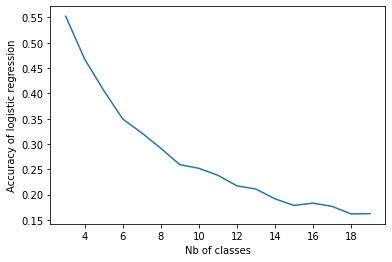

In [84]:
plt.plot(np.arange(3,20),np.mean(list_accuracy,axis=1))
plt.xlabel('Nb of classes')
plt.ylabel('Accuracy of logistic regression')
plt.savefig('logistic accuracy depending on nb class.png')
plt.show()

## Remove outliers ?

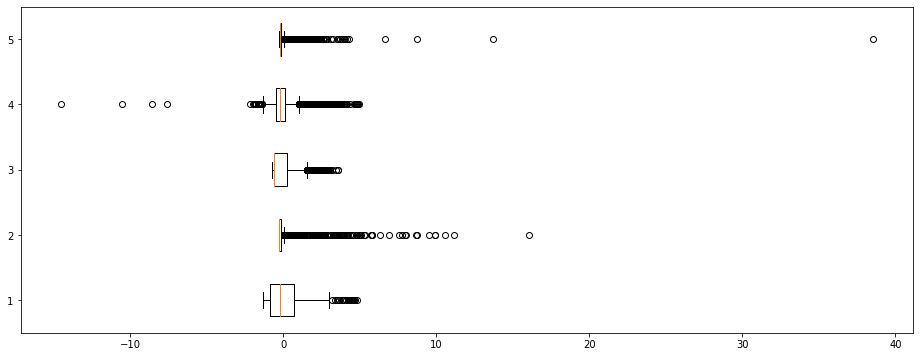

In [56]:
plt.figure(figsize=(16,6))
plt.boxplot(X,vert=False)
plt.show()

In [160]:
z = np.mean(np.abs(scipy.stats.zscore(X)),axis=1)

In [162]:
X_no_outliers = X[z<2]

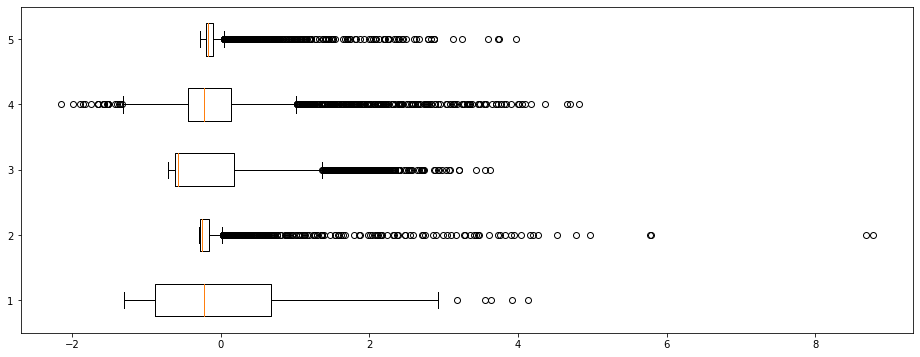

In [163]:
plt.figure(figsize=(16,6))
plt.boxplot(X_no_outliers,vert=False)
plt.show()

In [165]:
train_ind_no, test_ind_no = train_test_split(np.arange(len(X_no_outliers)),test_size=0.2)

X_train_no, X_test_no = X_no_outliers[train_ind_no], X_no_outliers[test_ind_no]
Y_train_no, Y_test_no = Y_star_maupiti[z<2][train_ind_no], Y_star_maupiti[z<2][test_ind_no]
Z_train_no, Z_test_no = Z_maupiti[z<2][train_ind_no], Z_maupiti[z<2][test_ind_no]

In [167]:
%%time
reg = dirichlet_regression.dirichletRegressor()
reg.fit(X_train_no, Y_train_no, parametrization='alternative', gamma_0=[0.], Z=Z_train_no)

Optimization terminated successfully.
Wall time: 240 ms


In [169]:
r2_score(Y_train_no,reg.mu)

-0.3502475307954188

In [171]:
cos_similarity(Y_train_no,reg.mu)

0.4932643461190025

In [170]:
mu_pred = reg.pred(X_test_no)
r2_score(Y_test_no,mu_pred)

-0.7216232124652745

In [161]:
np.where(z>2)

(array([ 506,  576,  724,  809,  847,  931,  989, 1108, 1171, 1194, 1268,
        1278, 1319, 1351, 1354, 1356, 1403, 1625, 1661, 1677, 1699, 1723,
        1743, 1779, 1824, 1856, 2043, 2096, 2113, 2154, 2225, 2268, 2296,
        2303, 2306, 2312], dtype=int64),)

## With 5 features

In [27]:
gamma_0 = [0.]

In [63]:
%%time
reg = dirichlet_regression.dirichletRegressor()
reg.fit(X_train, Y_train, parametrization='alternative', gamma_0=gamma_0, Z=Z_train)

Optimization terminated successfully.
Wall time: 782 ms


In [64]:
mu_pred = reg.pred(X_test)

In [66]:
r2_score(Y_train,reg.mu)

-0.3074978247701289

In [67]:
cos_similarity(Y_train,reg.mu)

0.4913747870507699

In [65]:
r2_score(Y_test,mu_pred)

-0.14830795844616956

In [68]:
l_lambda_reg = np.arange(0, 1.5, 0.1)

In [69]:
%%time
l_r2_train = []
l_similarity_train = []
l_r2_test = []
l_similarity_test = []
for lambda_reg in l_lambda_reg:
    reg = dirichlet_regression.dirichletRegressor()
    reg.fit(X_train, Y_train, parametrization='alternative', gamma_0=gamma_0, Z=Z_train, regularization=lambda_reg)
    l_r2_train.append(r2_score(Y_train,reg.mu))
    l_similarity_train.append(cos_similarity(Y_train,reg.mu))
    mu_pred = reg.pred(X_test)
    l_r2_test.append(r2_score(Y_test,mu_pred))
    l_similarity_test.append(cos_similarity(Y_test,mu_pred))

Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Wall time: 5.33 s


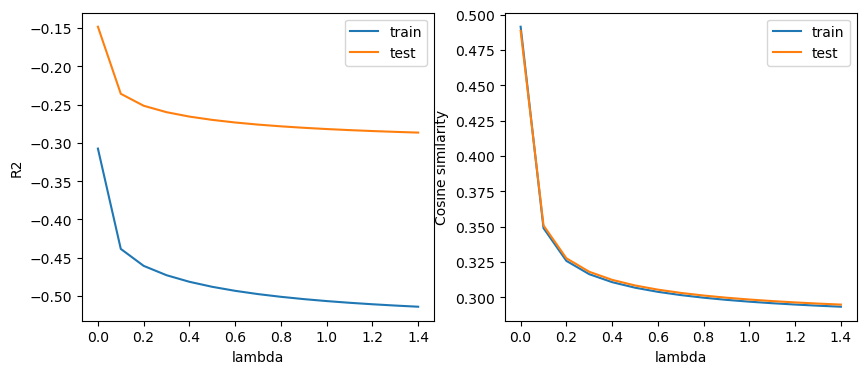

In [70]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].plot(l_lambda_reg, l_r2_train, label='train')
ax[0].plot(l_lambda_reg, l_r2_test, label='test')
ax[0].set_xlabel("lambda")
ax[0].set_ylabel("R2")
ax[0].legend()

ax[1].plot(l_lambda_reg, l_similarity_train, label='train')
ax[1].plot(l_lambda_reg, l_similarity_test, label='test')
ax[1].set_xlabel("lambda")
ax[1].set_ylabel("Cosine similarity")
ax[1].legend()

plt.show()

In [34]:
%%time
reg = dirichlet_regression.dirichletRegressor(spatial=True)
reg.fit(X_train, Y_train, W=W_train, parametrization='alternative', gamma_0=gamma_0, Z=Z_train)

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Wall time: 1min 46s


In [35]:
r2_score(Y_train,reg.mu)

-0.36315396767676866

# Reducing the number of classes

In [36]:
print([(zones[i],np.arange(15)[i]) for i in range(15)])

[('NONE', 0), ('CAER', 1), ('CCDR', 2), ('CFCO', 3), ('CMCD', 4), ('CRER', 5), ('CSAG', 6), ('CSHR', 7), ('CTSR', 8), ('DW', 9), ('SDS', 10), ('SLSC', 11), ('SMSC', 12), ('SSS', 13), ('SSSC', 14)]


In [32]:
Y_7 = np.zeros((n_samples,7))

In [37]:
Y_7[:,0] = Y_maupiti[:,0] + Y_maupiti[:,9] #OTHER + DW
Y_7[:,1] = Y_maupiti[:,11] + Y_maupiti[:,14] +Y_maupiti[:,12] #S-LSC + S-SSC + S-MSC
Y_7[:,2] = Y_maupiti[:,13] + Y_maupiti[:,10]  #S-SS + S-DS
Y_7[:,3] = Y_maupiti[:,3] + Y_maupiti[:,4]  #C-FCO + C-MCD
Y_7[:,4] = Y_maupiti[:,8] + Y_maupiti[:,7]  + Y_maupiti[:,1] + Y_maupiti[:,2]  #C-TSR + C-SHR + C-AER + C-CDR
Y_7[:,5] = Y_maupiti[:,5] #C-RER
Y_7[:,6] = Y_maupiti[:,6] #C-SAG

In [39]:
Y_7_star = (Y_7*(n_samples-1)+1/7)/n_samples

In [55]:
Y_5 = np.zeros((n_samples,5))
Y_5[:,0] = Y_maupiti[:,0] + Y_maupiti[:,9] #OTHER + DW
Y_5[:,1] = Y_maupiti[:,13] +  Y_maupiti[:,10] + Y_maupiti[:,11] + Y_maupiti[:,14] #S-SS + S-DS + S-LSC + S-SSC
Y_5[:,2] = Y_maupiti[:,12] + Y_maupiti[:,3] + Y_maupiti[:,4] + Y_maupiti[:,8] + Y_maupiti[:,7]  + Y_maupiti[:,1] + Y_maupiti[:,2]  #S-MSC + C-FCO + C-MCD + C-TSR + C-SHR + C-AER + C-CDR
Y_5[:,3] = Y_maupiti[:,5] #C-RER
Y_5[:,4] = Y_maupiti[:,6] #C-SAG

In [57]:
Y_5_star = (Y_5*(n_samples-1)+1/5)/n_samples

In [50]:
reg_15 = dirichlet_regression.dirichletRegressor()
reg_15.fit(X, Y_star_maupiti, parametrization='alternative', Z=np.ones((n_samples,1)))

Optimization terminated successfully.


In [51]:
print(r2_score(Y_star_maupiti,reg_15.mu))
print(cos_similarity(Y_star_maupiti,reg_15.mu))

-0.33920109332438525
0.49005500362134213


In [52]:
reg_7 = dirichlet_regression.dirichletRegressor()
reg_7.fit(X, Y_7_star, parametrization='alternative', Z=np.ones((n_samples,1)))

Optimization terminated successfully.


In [56]:
print(r2_score(Y_7,reg_7.mu))
print(cos_similarity(Y_7,reg_7.mu))

0.046513379148061675
0.6275671654654797


In [58]:
reg_5 = dirichlet_regression.dirichletRegressor()
reg_5.fit(X, Y_5_star, parametrization='alternative', Z=np.ones((n_samples,1)))

Optimization terminated successfully.


In [59]:
print(r2_score(Y_5,reg_5.mu))
print(cos_similarity(Y_5,reg_5.mu))

0.1093883598023551
0.7327814686388259
